In [1]:
from itertools import product
import logging
L = logging.getLogger(__name__)
from pathlib import Path
import pickle
import yaml

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("..")
from berp.datasets import BerpDataset, NestedBerpDataset
from berp.datasets.base import assert_compatible
from berp.datasets.eeg import load_eeg_dataset
from berp.datasets.splitters import KFold, train_test_split
import berp.trainer  # sets some nice yaml dump defaults
from berp.viz.trf import plot_trf_coefficients

In [66]:
workflow = "heilbron2022"
model = "distilgpt2"

base_model_run_name = "trf.20221214"
trf_run_name = "trf-berp-fixed.20221214"
# trf_run_name = "trf-berp-cannon.20221214.2quant"

subjects = [17, 18, 19]
runs = list(range(1, 20))
stories = ["old-man-and-the-sea"]

target_sensors = ["A1", "A2", "B1", "D15"]

# Match dataset spec.
normalize_X_ts = False
normalize_X_variable = False
normalize_Y = True

n_evaluation_folds = 4

In [67]:
all_run_names = [base_model_run_name, trf_run_name]
model_dirs = [f"../workflow/{workflow}/results/{model}/{run_name}"
              for run_name in all_run_names]
dataset_dir = f"../workflow/{workflow}/data/dataset/{model}"
stimulus_dir = f"../workflow/{workflow}/data/stimulus/{model}"

## Prepare dataset

In [6]:
# Load datasets.
ds = {}
stimulus_paths = {f"{story}/run{run}": Path(stimulus_dir) / f"{story}/run{run}.pkl"
                  for story in stories for run in runs}
combs = list(product(stories, subjects, runs))
for story, subject, run in tqdm(combs):
    ds_path = Path(dataset_dir) / story / f"sub{subject}" / f"run{run}.pkl"
    if not ds_path.exists():
        print(f"Could not find dataset {ds_path}")
        continue

    ds[story, subject, run] = load_eeg_dataset(
        [ds_path], subset_sensors=target_sensors,
        stimulus_paths=stimulus_paths,
        normalize_X_ts=normalize_X_ts, normalize_X_variable=normalize_X_variable, normalize_Y=normalize_Y).datasets[0]

  0%|          | 0/57 [00:00<?, ?it/s]

In [7]:
ds = NestedBerpDataset(list(ds.values()), n_splits=8)
# TODO hack, just replicating what is in trainer.
ds_train, ds_test = train_test_split(ds, test_size=.25)

## Load and prime pipelines

In [68]:
pipes = []
for run in tqdm(model_dirs):
    pipeline_path = Path(run) / "params" / "pipeline.pkl"
    if not pipeline_path.exists():
        L.warn(f"Missing pipeline at {pipeline_path}")
        
    with pipeline_path.open("rb") as f:
        pipes.append(pickle.load(f))

  0%|          | 0/2 [00:00<?, ?it/s]

In [69]:
for run_name, pipe in zip(all_run_names, pipes):
    print(f"=============== {run_name}")
    yaml.safe_dump(pipe.get_params(), sys.stdout)
    print()

=============== trf.20221214
device: cpu
encoder: "TemporalReceptiveField(alpha=9861602184.638493, fit_intercept=True, n_outputs=4,\n\
  \                       name='78bddaeedf924ae5a4e0f3a9bd511369',\n             \
  \          optim=AdamSolver(n_batches=50,\n                                    \
  \    name='78bddaeedf924ae5a4e0f3a9bd511369',\n                                \
  \        random_state=RandomState(MT19937) at 0x2B2F82FAAE40),\n               \
  \        sfreq=128.0, tmax=0.5625, tmin=0.0)"
encoder__alpha: 9861602184.638493
encoder__fit_intercept: true
encoder__init_scale: 0.1
encoder__n_outputs: 4
encoder__name: 78bddaeedf924ae5a4e0f3a9bd511369
encoder__optim: "AdamSolver(n_batches=50, name='78bddaeedf924ae5a4e0f3a9bd511369',\n\
  \           random_state=RandomState(MT19937) at 0x2B2F82FAAE40)"
encoder__optim__batch_size: 512
encoder__optim__early_stopping: 5
encoder__optim__learning_rate: 0.01
encoder__optim__n_batches: 50
encoder__optim__name: 78bddaeedf924ae5a4e

In [70]:
for pipe in pipes:
    pipe.prime(ds)

## Estimate validation score

TODO this is not fair, we should use test set. NB we forgot the train test split above, which happens in Trainer.

In [71]:
splitter = KFold(n_splits=n_evaluation_folds)
all_scores = np.zeros((n_evaluation_folds, len(all_run_names), len(subjects), len(runs), len(target_sensors))) * np.nan
for i, (train, test) in enumerate(tqdm(splitter.split(ds), total=splitter.n_splits)):
    for j, (run_name, pipe) in enumerate(zip(tqdm(all_run_names, unit="pipe"), pipes)):
        all_scores[i, j] = pipe.score_multidimensional(ds[test]).reshape((len(subjects), len(runs), len(target_sensors)))

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?pipe/s]

  0%|          | 0/2 [00:00<?, ?pipe/s]

  0%|          | 0/2 [00:00<?, ?pipe/s]

  0%|          | 0/2 [00:00<?, ?pipe/s]

In [72]:
all_scores.max(axis=4).mean(axis=3).mean(axis=2).mean(axis=0)

array([0.03753354, 0.08588896])

In [73]:
all_run_names

['trf.20221214', 'trf-berp-fixed.20221214']

## Estimate test score

In [74]:
test_scores = np.zeros((len(all_run_names), len(subjects), len(runs), len(target_sensors))) * np.nan
for j, (run_name, pipe) in enumerate(zip(tqdm(all_run_names, unit="pipe"), pipes)):
    test_scores[j] = pipe.score_multidimensional(ds_test).reshape((len(subjects), len(runs), len(target_sensors)))

  0%|          | 0/2 [00:00<?, ?pipe/s]

In [75]:
test_scores.max(axis=-1).mean(axis=-1).mean(axis=-1)

array([0.01833564, 0.06308135])

In [76]:
(test_scores[1] - test_scores[0]).max(axis=-1).mean()

0.06119240141931202

### Bootstrap estimate

In [77]:
test_scores_df = []
for i_model_run, i_subj, i_run, i_sensor in np.ndindex(*test_scores.shape):
    test_scores_df.append((
        all_run_names[i_model_run],
        subjects[i_subj],
        runs[i_run],
        target_sensors[i_sensor],
        test_scores[i_model_run, i_subj, i_run, i_sensor]))
    
test_scores_df = pd.DataFrame(test_scores_df, columns=["model_run", "subject", "run", "sensor", "score"]).set_index(["model_run", "subject", "run", "sensor"])
test_scores_df

score
model_run               subject run sensor          
trf.20221214            17      1   A1     -0.025523
                                    A2     -0.003708
                                    B1     -0.041522
                                    D15    -0.040116
                                2   A1      0.052872
...                                              ...
trf-berp-fixed.20221214 19      18  D15     0.096798
                                19  A1      0.104067
                                    A2      0.069030
                                    B1      0.095110
                                    D15     0.080403

[456 rows x 1 columns]

<AxesSubplot:xlabel='model_run', ylabel='score'>

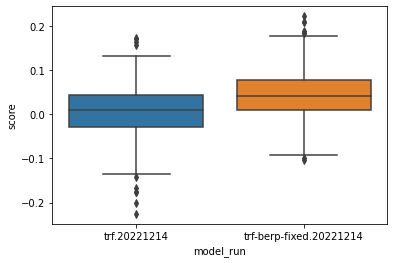

In [78]:
sns.boxplot(data=test_scores_df.reset_index(), x="model_run", y="score")

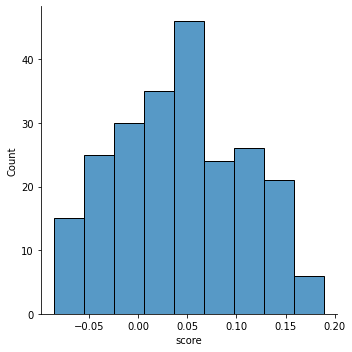

In [79]:
model_diffs = test_scores_df.loc[all_run_names[1]] - test_scores_df.loc[all_run_names[0]]
model_diffs = model_diffs.reset_index()
sns.displot(data=model_diffs, x="score")

95% bootstrap CI: [0.02521801 0.06308349]


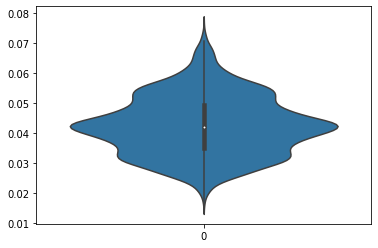

In [80]:
model_diffs_bootstrap = sns.algorithms.bootstrap(model_diffs.score, units=model_diffs.subject)
sns.violinplot(model_diffs_bootstrap)
print("95% bootstrap CI:",
      np.quantile(model_diffs_bootstrap, (0.025, 0.975)))

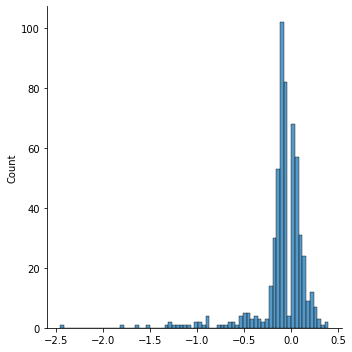

In [87]:
points, times = pipes[1].get_recognition_times(ds.datasets[0], pipes[1].params[0])
sns.displot(times - ds.datasets[0].word_onsets)

<AxesSubplot:ylabel='Count'>

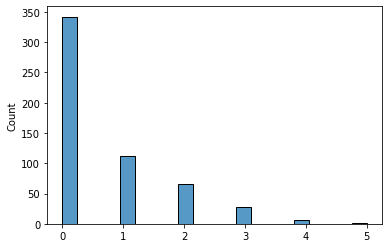

In [89]:
sns.histplot(points)